In [2]:
import numpy as np
import pandas as pd
import time
import re
from nltk import word_tokenize
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from nltk import FreqDist
import requests
from bs4 import BeautifulSoup
import pickle

### unpickling all dfs

In [3]:
df_bb = pd.read_pickle("./df_bb.pkl")
df_dmn = pd.read_pickle("./df_dmn.pkl")
df_mbw_2020 = pd.read_pickle("./df_mbw_2020.pkl")
df_mbw_2019 = pd.read_pickle("./df_mbw_2019.pkl")

### combining articles from all sources 

In [5]:
all_music_news_df = pd.concat([df_bb, df_dmn, df_mbw_2020, df_mbw_2019], axis = 0)

In [6]:
all_music_news_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2244 entries, 0 to 1819
Data columns (total 12 columns):
id                2244 non-null object
publishDate       2009 non-null object
discoverDate      2244 non-null object
title             2244 non-null object
language          2244 non-null object
text              2244 non-null object
structuredText    2244 non-null object
url               2244 non-null object
elements          2244 non-null object
website           2244 non-null object
metadata          2244 non-null object
score             2244 non-null float64
dtypes: float64(1), object(11)
memory usage: 227.9+ KB


### data cleaning

In [7]:
df = all_music_news_df

In [8]:
df.drop(['id', 'publishDate', 'title', 'language', 'structuredText', 'url', 'elements', 'website', 'metadata', 'score'], inplace=True, axis = 1)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2244 entries, 0 to 1819
Data columns (total 2 columns):
discoverDate    2244 non-null object
text            2244 non-null object
dtypes: object(2)
memory usage: 52.6+ KB


In [10]:
df.head()

,discoverDate,text
0,2020-02-28T18:24:00.966+0000,"On a recent rainy night in Manhattan, Kelsea B..."
1,2020-02-22T19:11:12.745+0000,Forget for a minute that the two men you thoug...
2,2020-02-19T23:22:46.545+0000,"[Editors note: In this ongoing series, we expl..."
3,2020-01-24T02:23:37.436+0000,As the music business continues to grow and ch...
4,2019-12-12T16:24:02.523+0000,"Desiree Perez COO, Roc Nation On a typical day..."


In [11]:
#pickling
df.to_pickle("./all_news_cleaned.pkl")

### tokenization

In [12]:
from sklearn.feature_extraction.text import CountVectorizer 
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import NMF
from sklearn.metrics.pairwise import cosine_similarity
from nltk.tokenize import word_tokenize
import nltk

In [13]:
#nltk.download('punkt')

In [14]:
# gensim
from gensim import corpora, models, similarities, matutils

# sklearn
from sklearn import datasets
from sklearn.feature_extraction.text import CountVectorizer

# logging for gensim (set to INFO)
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [15]:
# libraries for visualization
import pyLDAvis
import pyLDAvis.gensim
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [16]:
#creating tokenization column
df['tokenized'] = df.apply(lambda row: nltk.word_tokenize(row['text']), axis=1)

In [17]:
#convert it from series to string
df.tokenized = df.tokenized.astype(str)

In [18]:
#make everything lowercase 
df['tokenized'] = df['tokenized'].str.lower()

In [19]:
# remove unwanted characters, numbers and symbols
df['tokenized'] = df['tokenized'].str.replace("[^a-zA-Z#]", " ")

In [20]:
# function to plot most frequent terms
def freq_words(x, terms = 30):
  all_words = ' '.join([text for text in x])
  all_words = all_words.split()

  fdist = FreqDist(all_words)
  words_df = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())})

  # selecting top 20 most frequent words
  d = words_df.nlargest(columns="count", n = terms) 
  plt.figure(figsize=(20,5))
  ax = sns.barplot(data=d, x= "word", y = "count")
  ax.set(ylabel = 'Count')
  plt.show()

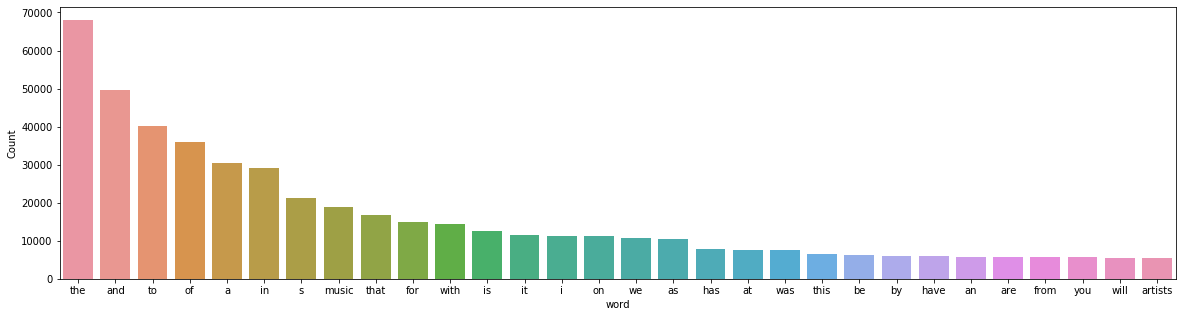

In [21]:
#1st visualization 
#frequency visualization before removing stopwords, stemming and lammatization 
freq_words(df['tokenized'])

### remove stopwords 

In [22]:
from nltk.corpus import stopwords
other_words = ['music business worldwide', 'digital music news', 'billboard', 'mbw', 'said', 'says', 'artists', 'also', 'one', 'like', 'music', 'business', 'including']
stop_words = stopwords.words('english') + other_words

In [23]:
# function to remove stopwords
def remove_stopwords(art):
    art_new = " ".join([i for i in art if i not in stop_words])
    return art_new

#remove short words (length < 3)
df['tokenized'] = df['tokenized'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>2]))

# remove stopwords from the text
df['tokenized'] = [remove_stopwords(r.split()) for r in df['tokenized']]

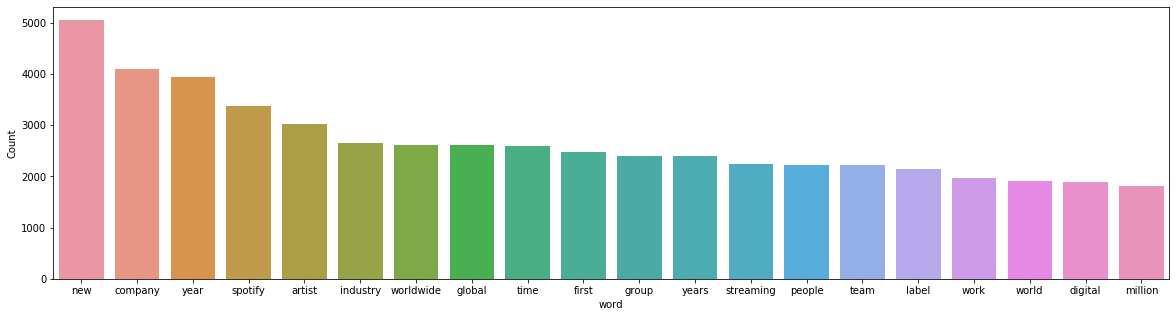

In [24]:
#top 20 words after stopwords removal
freq_words(df['tokenized'], 20)

In [25]:
#pickling tokenized df
df.to_pickle("./tokenized.pkl")

In [26]:
df.head()

,discoverDate,text,tokenized
0,2020-02-28T18:24:00.966+0000,"On a recent rainy night in Manhattan, Kelsea B...",recent rainy night manhattan kelsea ballerini ...
1,2020-02-22T19:11:12.745+0000,Forget for a minute that the two men you thoug...,forget minute two men thought sang milli vanil...
2,2020-02-19T23:22:46.545+0000,"[Editors note: In this ongoing series, we expl...",editors note ongoing series explore best buzzw...
3,2020-01-24T02:23:37.436+0000,As the music business continues to grow and ch...,continues grow change decided time annual powe...
4,2019-12-12T16:24:02.523+0000,"Desiree Perez COO, Roc Nation On a typical day...",desiree perez coo roc nation typical day desir...


### change date format

In [32]:
ser1 = pd.Series(df['discoverDate']) 
new = df['discoverDate'].str.split("T", n =1 , expand = True)
df['date']= new[0]  

In [33]:
df.drop(['discoverDate'], axis=1, inplace=True)

In [34]:
df.head()

,text,tokenized,date
0,"On a recent rainy night in Manhattan, Kelsea B...",recent rainy night manhattan kelsea ballerini ...,2020-02-28
1,Forget for a minute that the two men you thoug...,forget minute two men thought sang milli vanil...,2020-02-22
2,"[Editors note: In this ongoing series, we expl...",editors note ongoing series explore best buzzw...,2020-02-19
3,As the music business continues to grow and ch...,continues grow change decided time annual powe...,2020-01-24
4,"Desiree Perez COO, Roc Nation On a typical day...",desiree perez coo roc nation typical day desir...,2019-12-12


In [36]:
df = df[['date','tokenized']]

In [37]:
#pickling
df.to_pickle("./preprocessed.pkl")